In [5]:
from preamble import *
from preamble import visits, systeminfo

# Define the Models

In [36]:
def transit_model(parameters, t):

    params = batman.TransitParams()
    
    #fixed parameters
    params.per = systeminfo['T_orb (d)'].value                       #orbital period
    params.inc = systeminfo['inclination']                     #orbital inclination (in degrees)
    params.ecc = systeminfo['eccentricity']                    #eccentricity
    params.w = systeminfo['longitude_of_periastron']                     #longitude of periastron (in degrees)

    #variables
    params.t0 = parameters['t0']                      #time of inferior conjunction
    params.rp = parameters['rp_rstar']                      #planet radius (in units of stellar radii)
    params.a = parameters['a_rstar']                       #semi-major axis (in units of stellar radii)
    params.limb_dark = "logarithmic"                     #limb darkening model
    params.u = visits[f'{visit}']['broadband_ldcs']               #limb darkening coefficients [u1, u2]
        
    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params)       #calculates light curve
    
    return flux

In [38]:
def rampProfile(parameters, t):
    
    """Ramp profile for single directional scan

    And RECTE model parameters: number of traps, trapping coeeficient
    and trap life time

    :param crate: average count rate in electron/second
    :param slope: visit-long slope
    :param dTrap_s: extra trapped slow charges between orbits
    :param dTrap_f: extra trapped fast charges between orbits
    :param trap_pop_s: initially trapped slow charges
    :param trap_pop_f: initially trapped fast charges
    :param tExp: beginning of each exposure
    :param expTime: exposure time
    :returns: observed counts
    :rtype: numpy.array

    """
    crate = parameters['crate']
    slope = parameters['slope']
    trap_pop_s = parameters['trap_pop_s']
    trap_pop_f = parameters['trap_pop_f']
    dTrap_s = parameters['dTrap_s']
    dTrap_f = parameters['dTrap_f']

    tExp = t * 24 * 60 *60 
    tExp = tExp-tExp[0]
    
    cRates = crate * (1 + tExp * slope / 1e7) / expTime
    
    obsCounts = RECTE(
        cRates,
        tExp,
        expTime,
        trap_pop_s,
        trap_pop_f,
        dTrap_s=[dTrap_s],
        dTrap_f=[dTrap_f],
        dt0=[0],
        lost=0,
        mode='scanning')
    
    return obsCounts

In [40]:
def breathing_effect(parameters, t):

    hst_orbital_period = 95.25 # minutes

    phase1 = ((t-t.min()) * 24*60) / hst_orbital_period     # the data point at time "epoch" will be the zero-point; convert int phase by division through period
    phase2 = np.floor(phase1)            # identify integer intervals of phase (where phase is between 0-1, between 1-2, between 2-3 and over 3)
    phase = phase1 - phase2              # make phase be in interval from 0 to 1
    toobig = np.where(phase > 0.5)[0]    # figure out where phase is bigger than 0.5
    if toobig.size > 0:
        phase[toobig] -= 1.0                 # and where it is bigger than 0.5 indeed, subtract one to get to interval [-0.5, 0.5]
    
    a = parameters['breathing_a']
    b = parameters['breathing_b']
    c = parameters['breathing_c']
    d = parameters['breathing_d']
    e = parameters['breathing_e']
    """
    Calculate the value of a fourth-order polynomial: ax^4 + bx^3 + cx^2 + dx + e
    
    Parameters:
    a (float): Coefficient for the x^3 term
    b (float): Coefficient for the x^2 term
    c (float): Coefficient for the x term
    d (float): Constant term
    
    Returns:
    float: The result of the polynomial evaluation
    """

    breathing_model = (a*phase**4 + b*phase**3 + c*phase**2 + d*phase + e)
    return breathing_model

In [42]:
def lnprob(parameters, t):

    ln_like=0.0

    model = rampProfile(parameters, t) * transit_model(parameters, t) # * breathing_effect(parameters, t)

    chisq = np.nansum( ((data_flux-model)**2)/(data_err**2) )
    reduced_chisq = chisq / (len(t)-len(parameters))
    err_weight = np.nansum(1./np.sqrt(2.*np.pi*(data_err)))
    
    ln_like += (err_weight - 0.5*chisq)
    
    return ln_like

In [44]:
def residual(parameters, t, y):
    
    model = rampProfile(parameters, t) * transit_model(parameters, t) # * breathing_effect(parameters, t) 

    residual = (y - model)/data_err

    # Check for NaNs in the residuals and handle them
    if np.any(np.isnan(residual)):
        print(parameters)
        print('ramp:',rampProfile(parameters, t))
        # print('breathing:',breathing_effect(parameters, t))
        print('transit:',transit_model(parameters, t))
        
        # raise ValueError("NaNs encountered in residuals.")

        return np.inf * np.ones_like(y)
    
    else:
        return residual

In [46]:
# Directory to save results
output_dir = "../data/lightcurvefits/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to save parameters to a file
def save_params_to_file(params, filename):
    with open(filename, 'w') as f:
        for name, param in params.items():
            stderr = param.stderr if param.stderr is not None else 'N/A'
            f.write(f'{name}: {param.value:.6f} ± {stderr}\n')

Running  F21 Forward



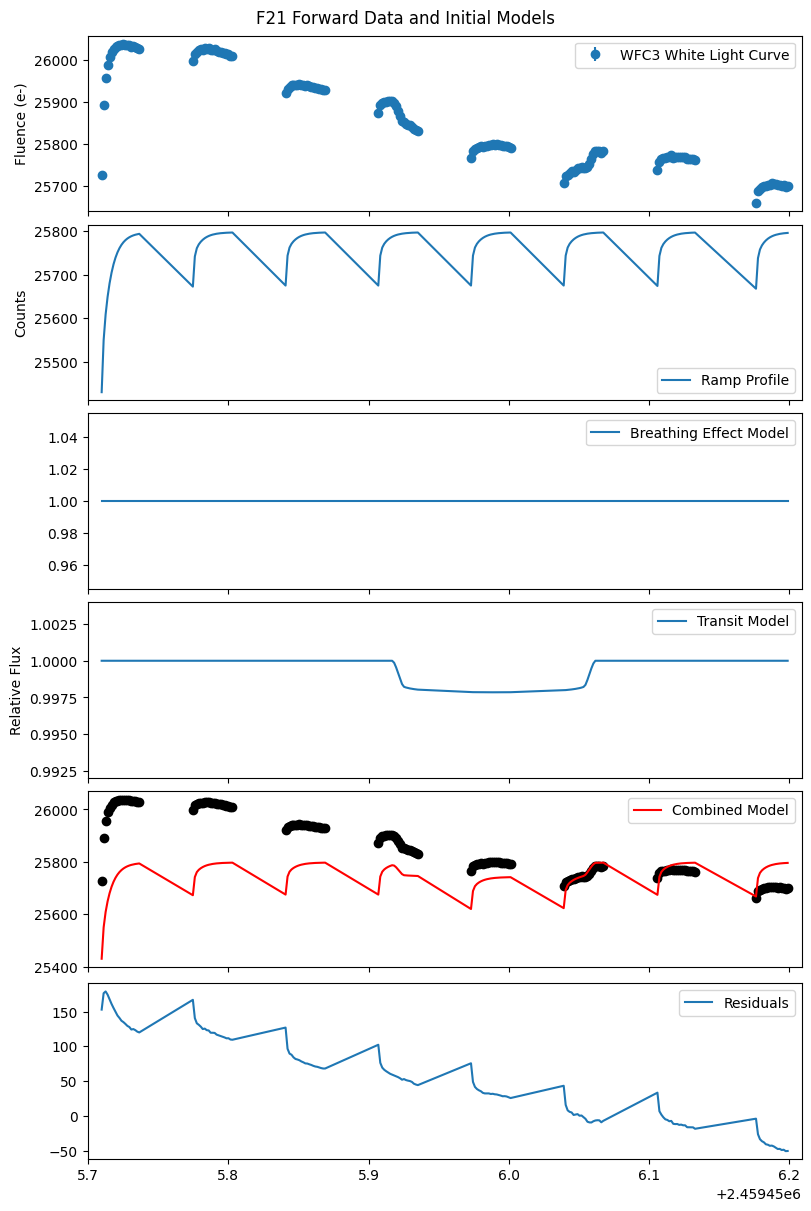

Parameters([('slope', <Parameter 'slope', value=-3.374459931688535, bounds=[-10:5]>), ('trap_pop_s', <Parameter 'trap_pop_s', value=725.6876446648863, bounds=[0:1000]>), ('trap_pop_f', <Parameter 'trap_pop_f', value=1.8699833006621813, bounds=[0:1000]>), ('dTrap_f', <Parameter 'dTrap_f', value=308.1636332816092, bounds=[0:1000]>), ('dTrap_s', <Parameter 'dTrap_s', value=543.0998738370836, bounds=[0:1000]>), ('t0', <Parameter 't0', value=2459455.9912139815, bounds=[2459455.9695:2459456.0095]>), ('rp_rstar', <Parameter 'rp_rstar', value=0.0476092960373755, bounds=[0.042:0.055]>), ('a_rstar', <Parameter 'a_rstar', value=17.05636991817389, bounds=[16.5:18.5]>), ('breathing_a', <Parameter 'breathing_a', value=-1.043867275874434, bounds=[-inf:inf]>), ('breathing_b', <Parameter 'breathing_b', value=0.9779500535382104, bounds=[-inf:inf]>), ('breathing_c', <Parameter 'breathing_c', value=-0.324921411258056, bounds=[-inf:inf]>), ('breathing_d', <Parameter 'breathing_d', value=0.04627688215585264

<Figure size 640x480 with 0 Axes>

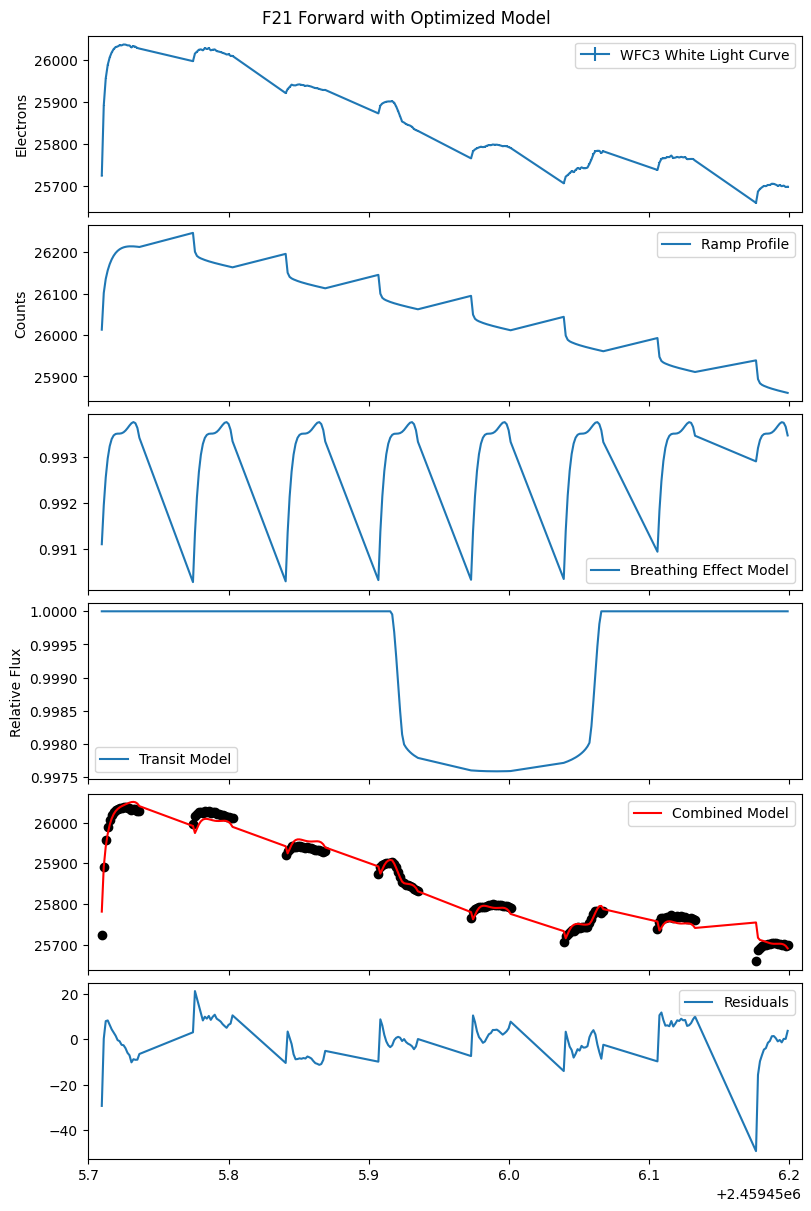

100%|██████████| 10000/10000 [07:28<00:00, 22.30it/s]


slope: -3.3745 ± 0.0062
trap_pop_s: 725.6673 ± 76.7361
trap_pop_f: 1.8700 ± 0.0004
dTrap_f: 308.1619 ± 6.7799
dTrap_s: 543.0708 ± 113.2776
t0: 2459455.9914 ± 276.7003
rp_rstar: 0.0476 ± 0.0002
a_rstar: 17.0568 ± 0.0303
breathing_a: -1.0438 ± 0.0037
breathing_b: 0.9779 ± 0.0031
breathing_c: -0.3249 ± 0.0015
breathing_d: 0.0463 ± 0.0004
breathing_e: 0.9910 ± 0.0207
crate: 26297.8978 ± 578.7662


<Figure size 640x480 with 0 Axes>

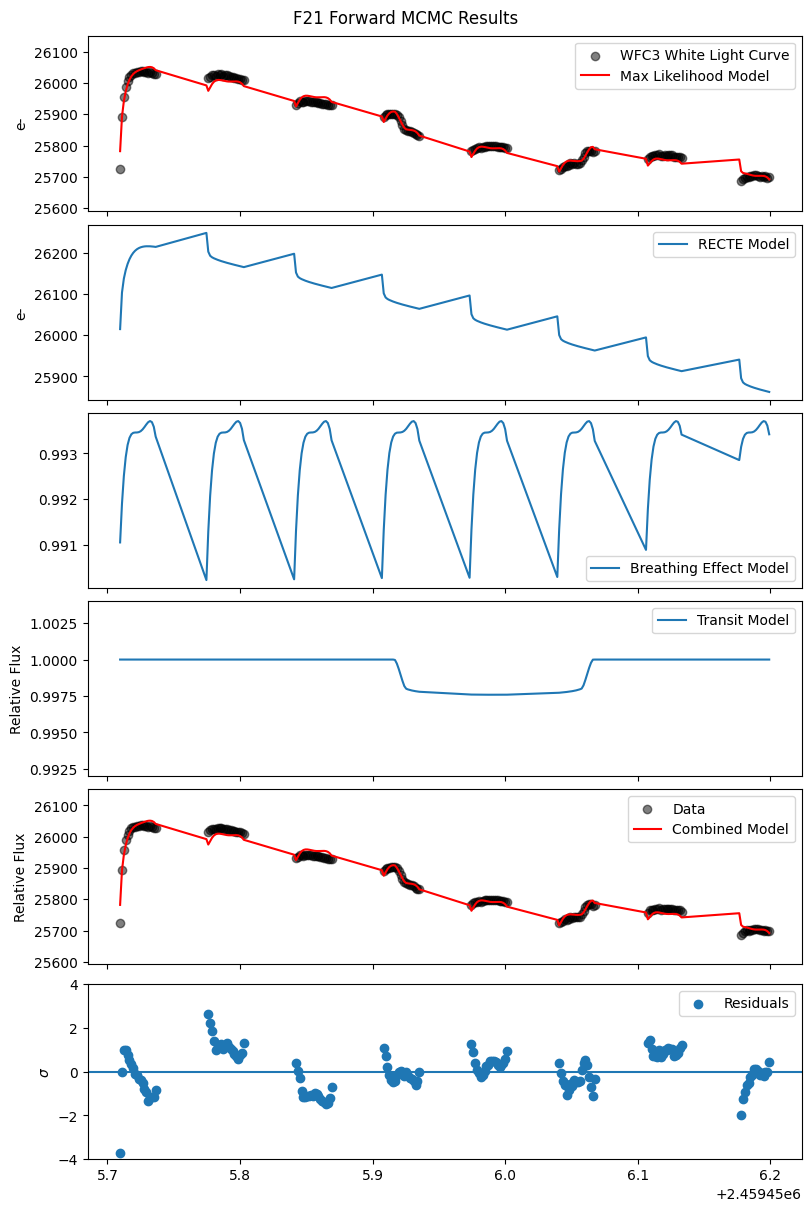

Saved LMFIT best-fit parameters to ../data/lightcurvefits/F21_Forward_lmfit_best_fit.txt
Saved EMCEE best-fit parameters to ../data/lightcurvefits/F21_Forward_emcee_best_fit.txt
Running  F21 Backward



<Figure size 640x480 with 0 Axes>

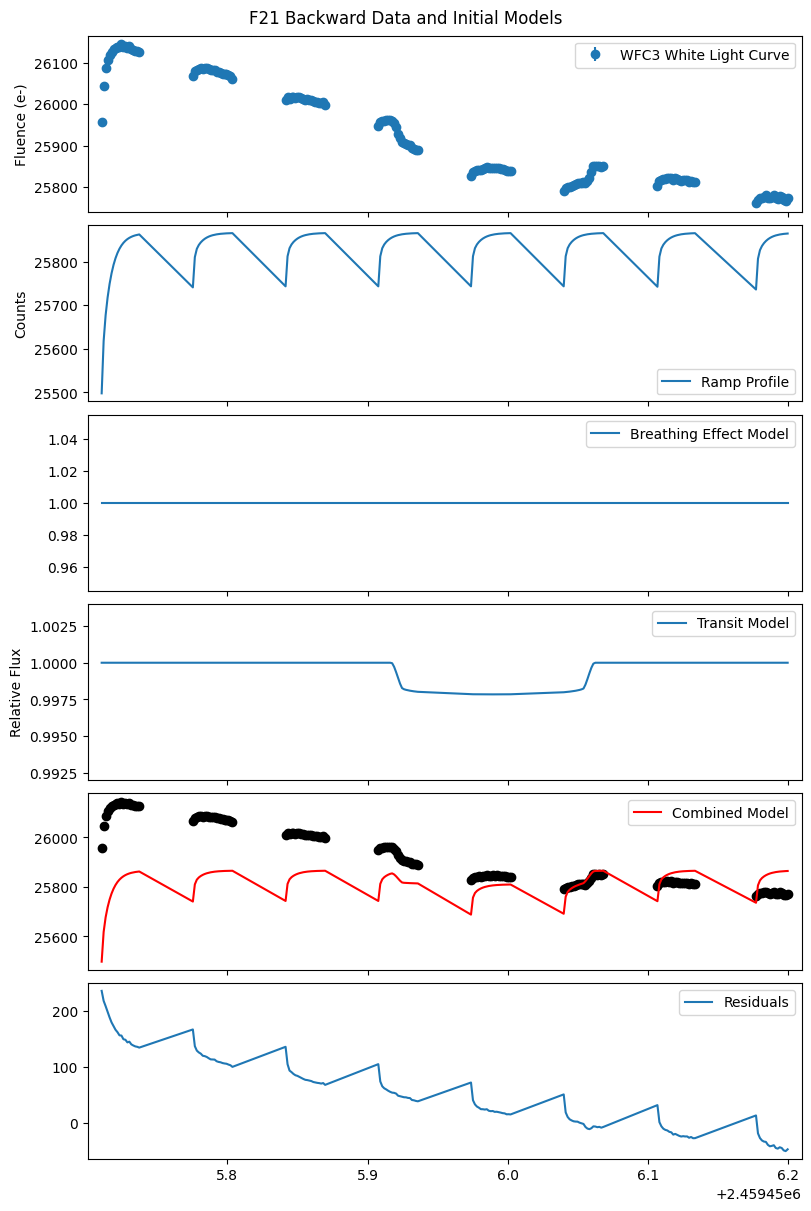

Parameters([('slope', <Parameter 'slope', value=-3.48008485322054, bounds=[-10:5]>), ('trap_pop_s', <Parameter 'trap_pop_s', value=843.892406307468, bounds=[0:1000]>), ('trap_pop_f', <Parameter 'trap_pop_f', value=328.79005182934776, bounds=[0:1000]>), ('dTrap_f', <Parameter 'dTrap_f', value=105.26684828908722, bounds=[0:1000]>), ('dTrap_s', <Parameter 'dTrap_s', value=528.5645366569235, bounds=[0:1000]>), ('t0', <Parameter 't0', value=2459455.9896587995, bounds=[2459455.9695:2459456.0095]>), ('rp_rstar', <Parameter 'rp_rstar', value=0.05249034070992929, bounds=[0.042:0.055]>), ('a_rstar', <Parameter 'a_rstar', value=17.058488882427486, bounds=[16.5:18.5]>), ('breathing_a', <Parameter 'breathing_a', value=-0.24271464711620797, bounds=[-inf:inf]>), ('breathing_b', <Parameter 'breathing_b', value=0.25118916666536634, bounds=[-inf:inf]>), ('breathing_c', <Parameter 'breathing_c', value=-0.09851262657475435, bounds=[-inf:inf]>), ('breathing_d', <Parameter 'breathing_d', value=0.01720675242

<Figure size 640x480 with 0 Axes>

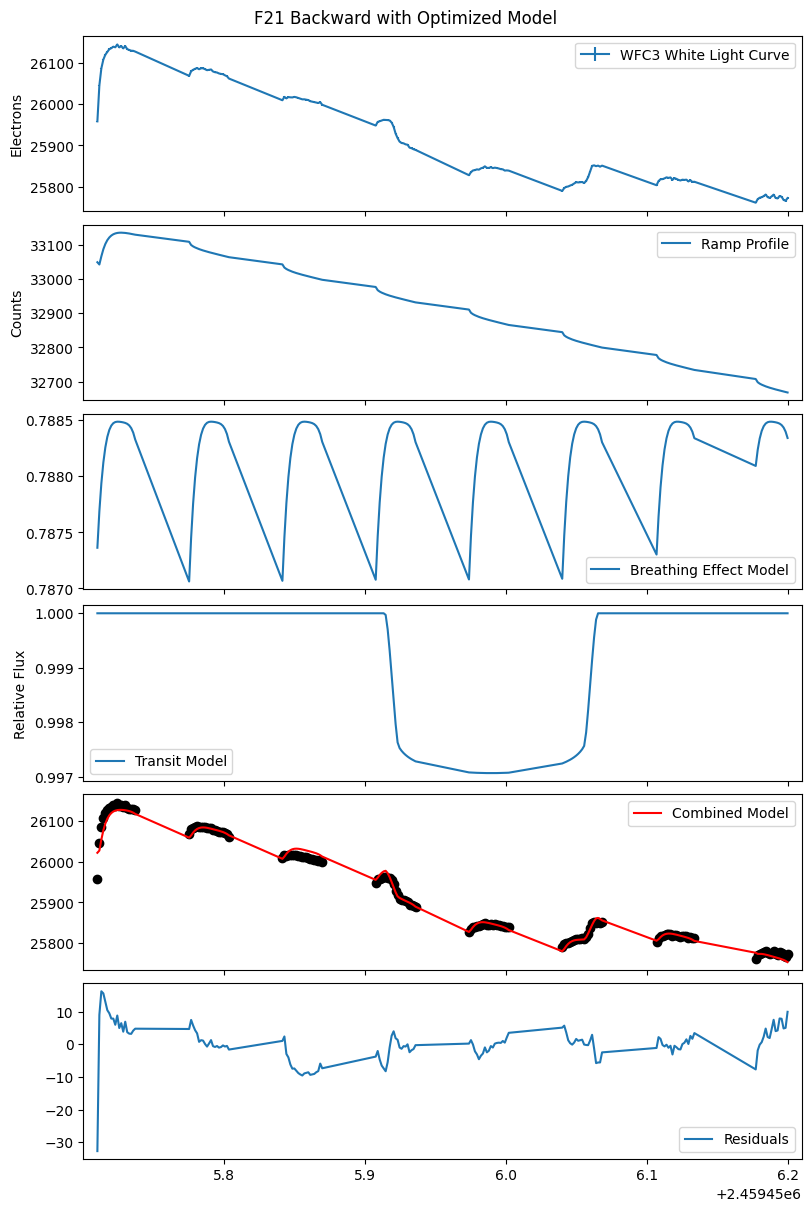

100%|██████████| 10000/10000 [03:51<00:00, 43.18it/s] 


slope: -3.4801 ± 0.0004
trap_pop_s: 843.8635 ± 2.5531
trap_pop_f: 328.7954 ± 0.4218
dTrap_f: 105.2678 ± 0.1346
dTrap_s: 528.5625 ± 0.0730
t0: 2459455.9896 ± 234.1077
rp_rstar: 0.0525 ± 0.0000
a_rstar: 17.0588 ± 0.0019
breathing_a: -0.2427 ± 0.0000
breathing_b: 0.2512 ± 0.0000
breathing_c: -0.0985 ± 0.0003
breathing_d: 0.0172 ± 0.0001
breathing_e: 0.7873 ± 0.0063
crate: 33220.3283 ± 268.2045


<Figure size 640x480 with 0 Axes>

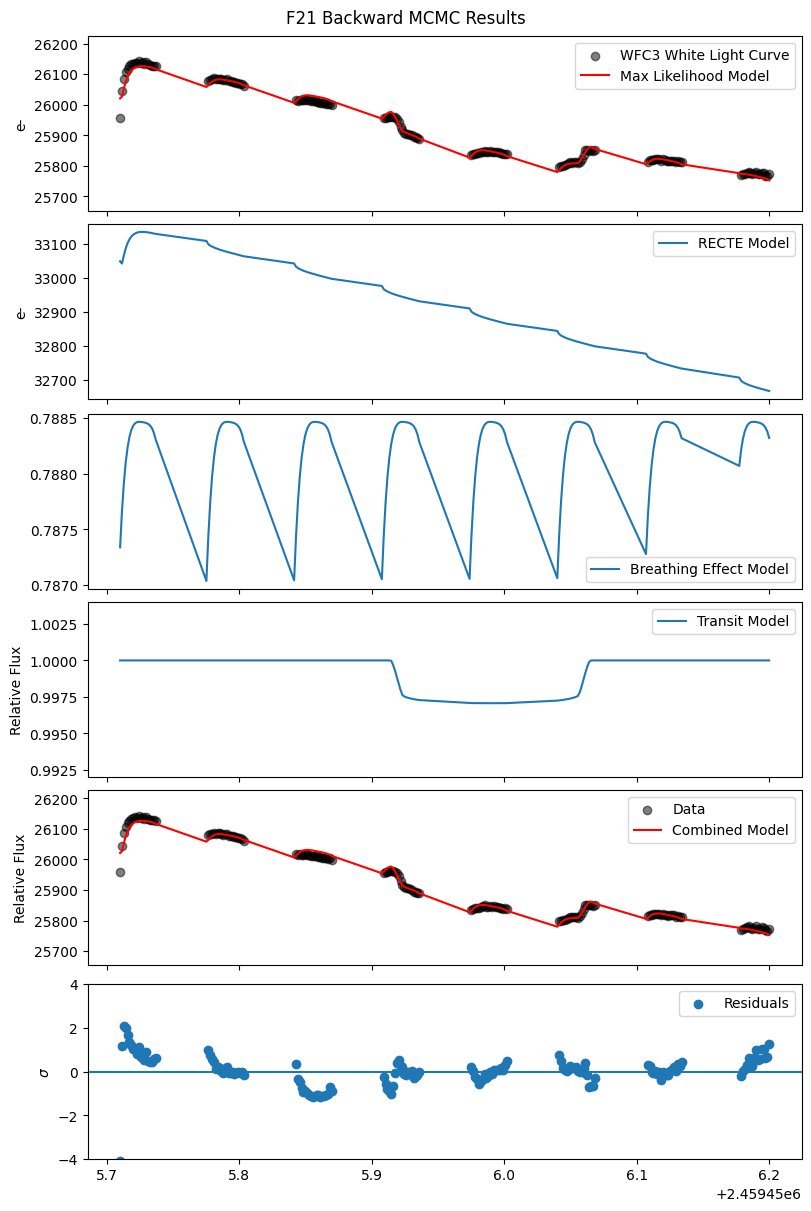

Saved LMFIT best-fit parameters to ../data/lightcurvefits/F21_Backward_lmfit_best_fit.txt
Saved EMCEE best-fit parameters to ../data/lightcurvefits/F21_Backward_emcee_best_fit.txt
Running  S22 Forward



<Figure size 640x480 with 0 Axes>

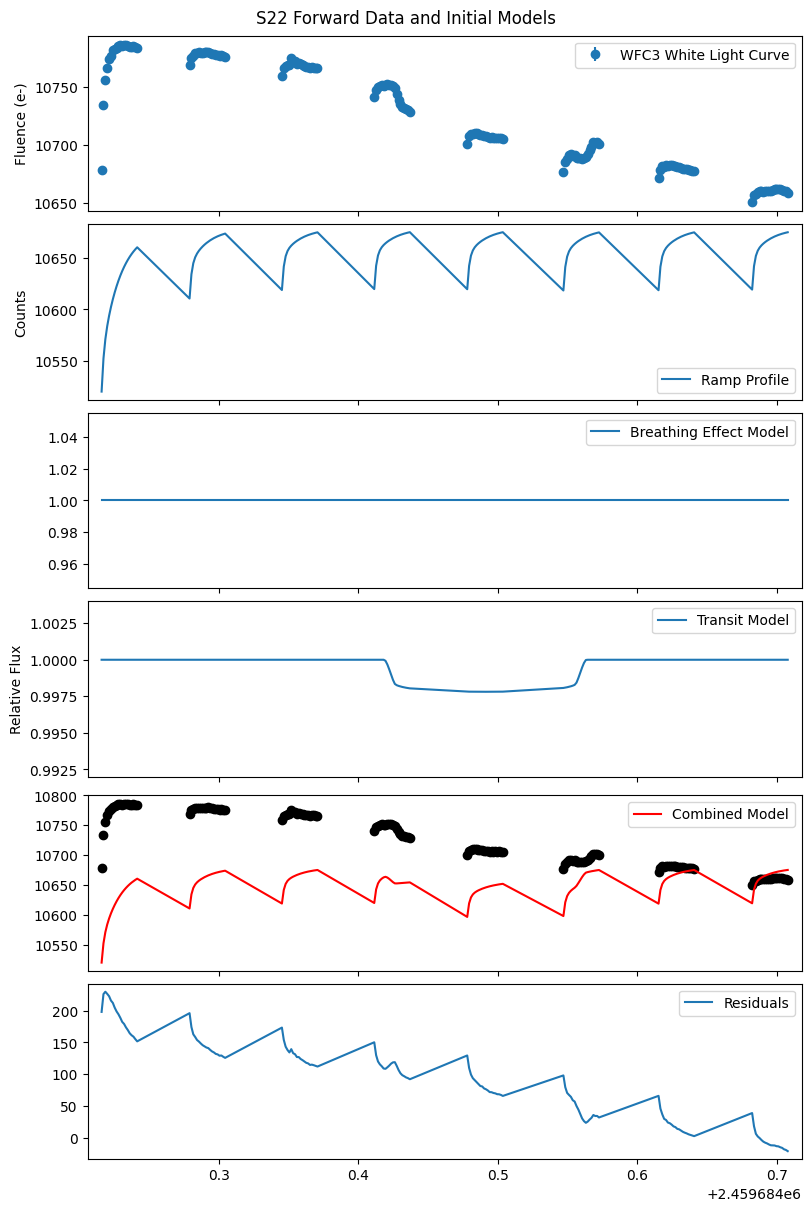

Parameters([('slope', <Parameter 'slope', value=-3.412439024069834, bounds=[-10:5]>), ('trap_pop_s', <Parameter 'trap_pop_s', value=200.07328168129425, bounds=[0:1000]>), ('trap_pop_f', <Parameter 'trap_pop_f', value=901.6519482426597, bounds=[0:1000]>), ('dTrap_f', <Parameter 'dTrap_f', value=201.15435451445717, bounds=[0:1000]>), ('dTrap_s', <Parameter 'dTrap_s', value=5.639430856258009, bounds=[0:1000]>), ('t0', <Parameter 't0', value=2459684.496682087, bounds=[2459684.471:2459684.511]>), ('rp_rstar', <Parameter 'rp_rstar', value=0.04200016632977857, bounds=[0.042:0.055]>), ('a_rstar', <Parameter 'a_rstar', value=17.588231976739525, bounds=[16.5:18.5]>), ('breathing_a', <Parameter 'breathing_a', value=-0.4961382515960053, bounds=[-inf:inf]>), ('breathing_b', <Parameter 'breathing_b', value=0.5996143553766838, bounds=[-inf:inf]>), ('breathing_c', <Parameter 'breathing_c', value=-0.2392314622974449, bounds=[-inf:inf]>), ('breathing_d', <Parameter 'breathing_d', value=0.032459269314625

<Figure size 640x480 with 0 Axes>

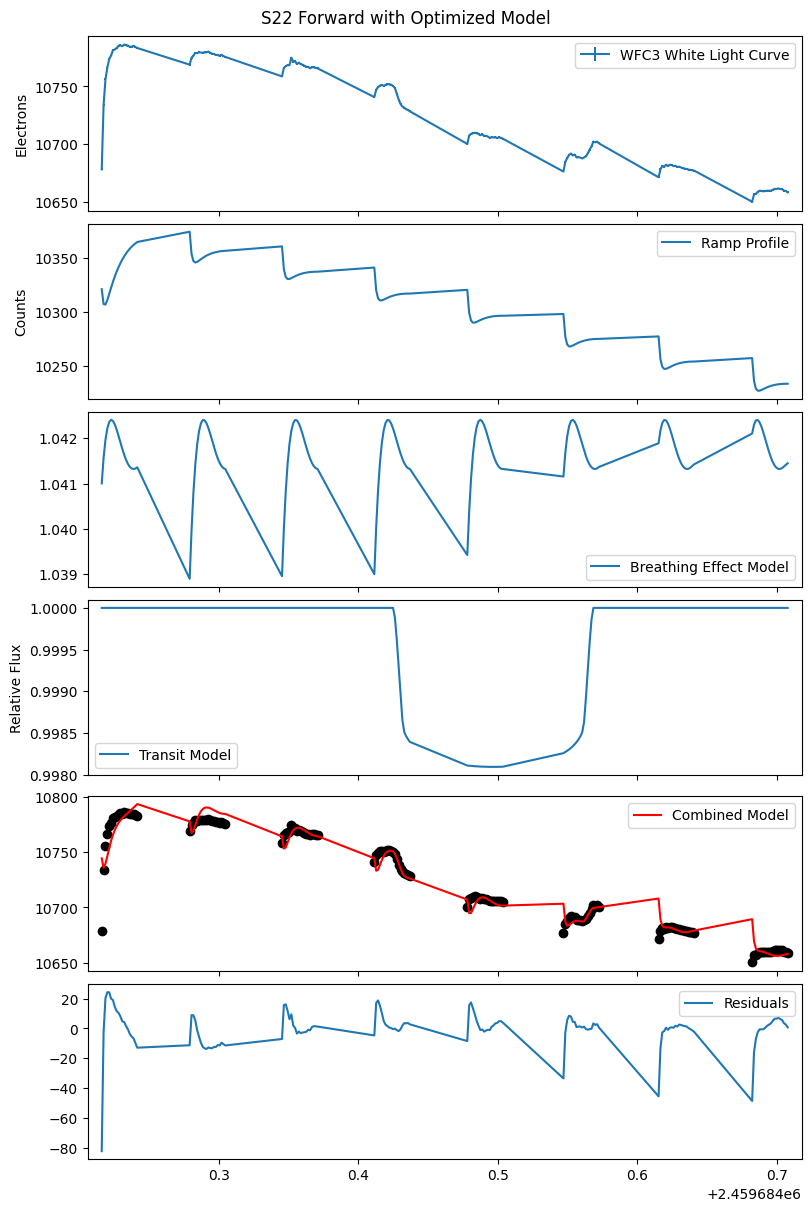

100%|██████████| 10000/10000 [03:39<00:00, 45.52it/s]


slope: -3.4124 ± 0.0025
trap_pop_s: 200.0739 ± 0.0319
trap_pop_f: 901.6349 ± 0.1338
dTrap_f: 201.1577 ± 0.0307
dTrap_s: 5.6394 ± 0.0008
t0: 2459684.4968 ± 244.4587
rp_rstar: 0.0420 ± 0.0000
a_rstar: 17.5886 ± 0.0024
breathing_a: -0.4961 ± 0.0001
breathing_b: 0.5996 ± 0.0005
breathing_c: -0.2392 ± 0.0002
breathing_d: 0.0325 ± 0.0001
breathing_e: 1.0410 ± 0.0017
crate: 10434.6784 ± 16.6977


<Figure size 640x480 with 0 Axes>

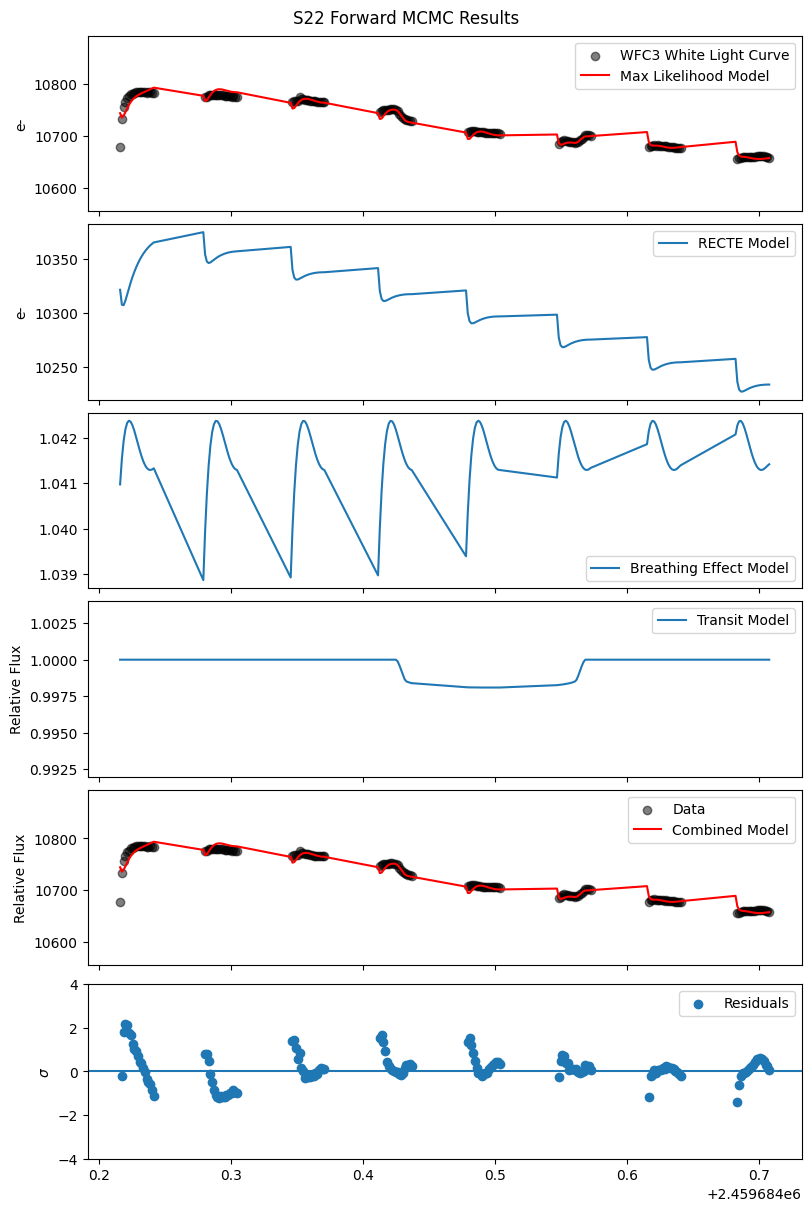

Saved LMFIT best-fit parameters to ../data/lightcurvefits/S22_Forward_lmfit_best_fit.txt
Saved EMCEE best-fit parameters to ../data/lightcurvefits/S22_Forward_emcee_best_fit.txt
Running  S22 Backward



<Figure size 640x480 with 0 Axes>

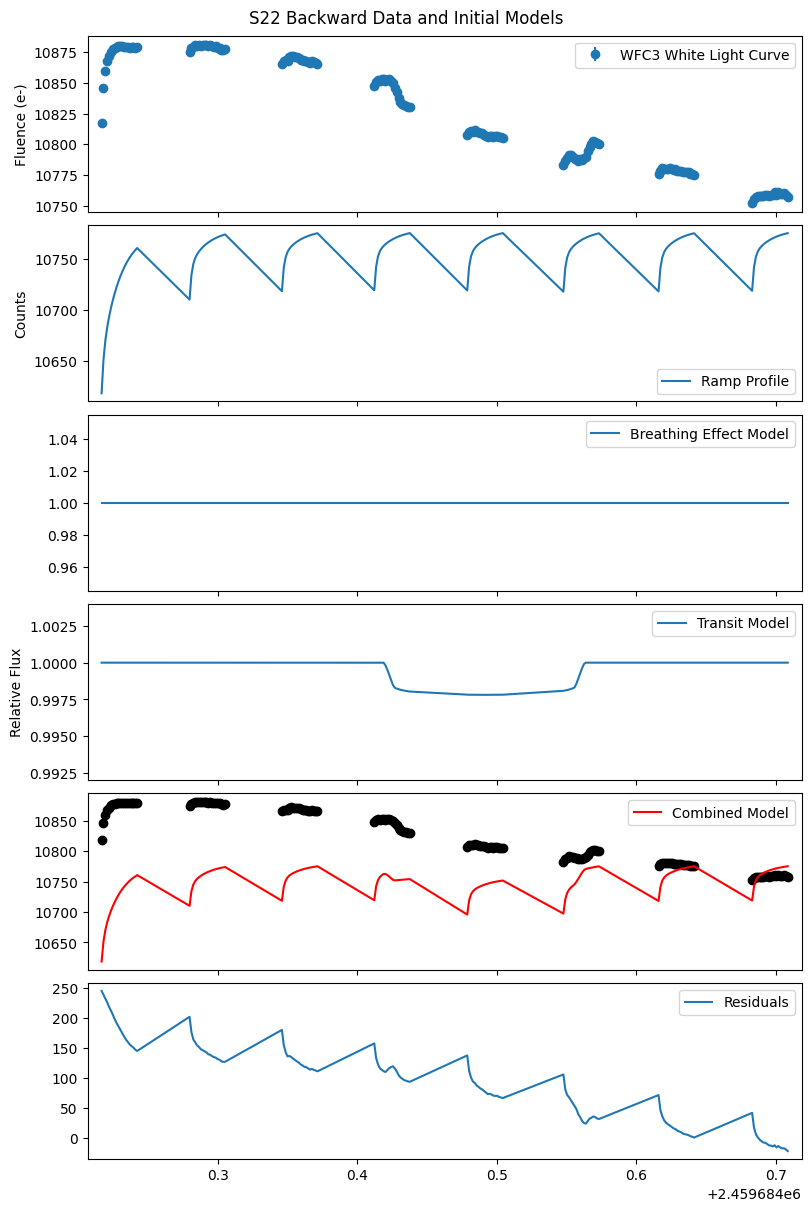

Parameters([('slope', <Parameter 'slope', value=-3.5082709568958217, bounds=[-10:5]>), ('trap_pop_s', <Parameter 'trap_pop_s', value=618.5309103131451, bounds=[0:1000]>), ('trap_pop_f', <Parameter 'trap_pop_f', value=714.9432431585421, bounds=[0:1000]>), ('dTrap_f', <Parameter 'dTrap_f', value=904.7657334172958, bounds=[0:1000]>), ('dTrap_s', <Parameter 'dTrap_s', value=884.1637203280543, bounds=[0:1000]>), ('t0', <Parameter 't0', value=2459684.497870803, bounds=[2459684.471:2459684.511]>), ('rp_rstar', <Parameter 'rp_rstar', value=0.04200002596310976, bounds=[0.042:0.055]>), ('a_rstar', <Parameter 'a_rstar', value=17.994720834593913, bounds=[16.5:18.5]>), ('breathing_a', <Parameter 'breathing_a', value=-0.5157585082535984, bounds=[-inf:inf]>), ('breathing_b', <Parameter 'breathing_b', value=0.5993823803255055, bounds=[-inf:inf]>), ('breathing_c', <Parameter 'breathing_c', value=-0.23903091477448024, bounds=[-inf:inf]>), ('breathing_d', <Parameter 'breathing_d', value=0.039578576286089

<Figure size 640x480 with 0 Axes>

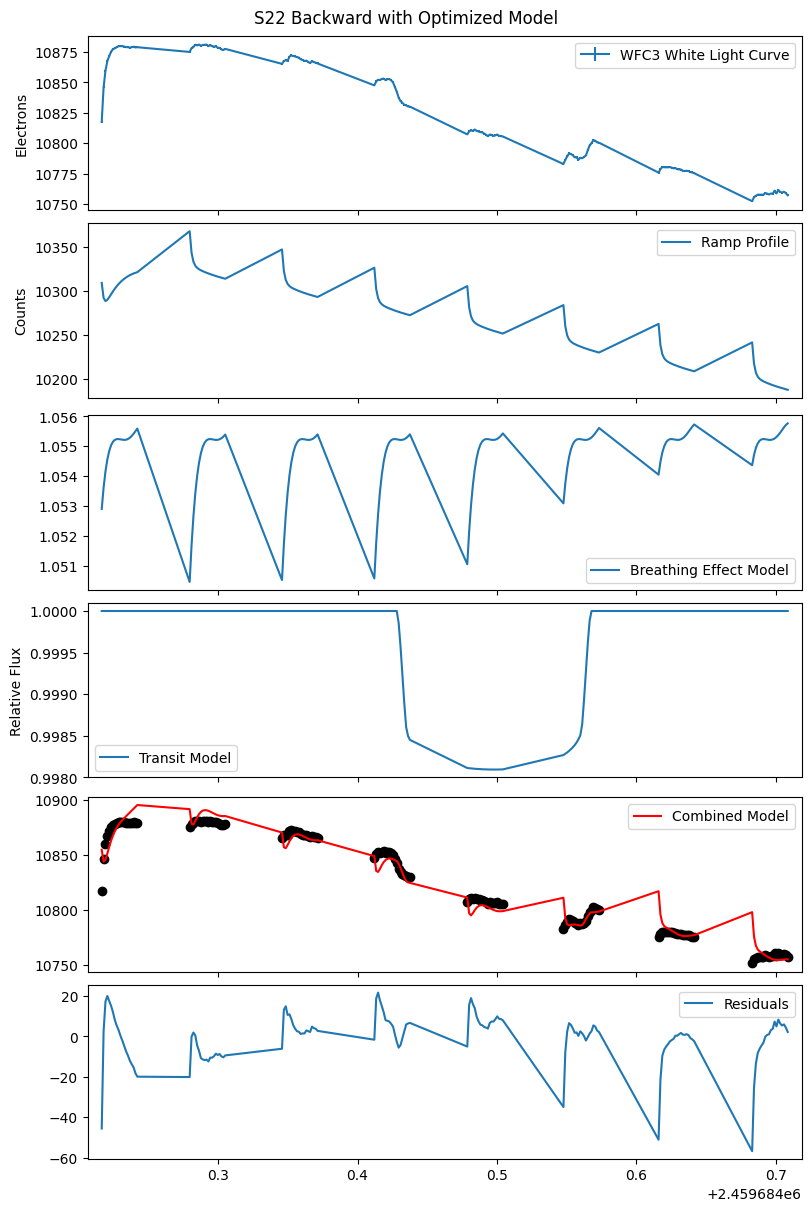

100%|██████████| 10000/10000 [01:15<00:00, 133.12it/s]


slope: -3.5084 ± 0.0004
trap_pop_s: 618.5346 ± 0.0704
trap_pop_f: 714.9669 ± 0.0951
dTrap_f: 904.7738 ± 0.1212
dTrap_s: 884.1597 ± 0.0989
t0: 2459684.4975 ± 282.9547
rp_rstar: 0.0420 ± 0.0000
a_rstar: 17.9942 ± 0.0021
breathing_a: -0.5158 ± 0.0001
breathing_b: 0.5994 ± 0.0001
breathing_c: -0.2390 ± 0.0000
breathing_d: 0.0396 ± 0.0000
breathing_e: 1.0529 ± 0.0002
crate: 10385.9286 ± 1.1631


<Figure size 640x480 with 0 Axes>

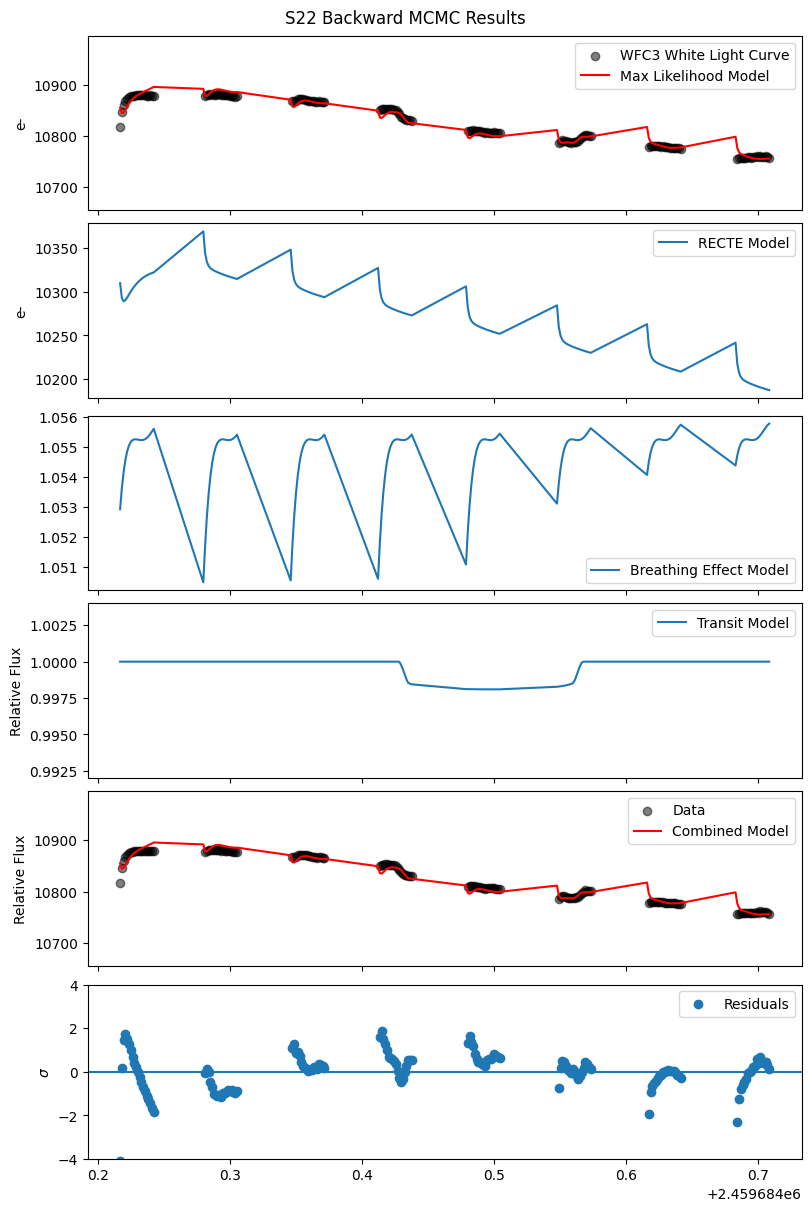

Saved LMFIT best-fit parameters to ../data/lightcurvefits/S22_Backward_lmfit_best_fit.txt
Saved EMCEE best-fit parameters to ../data/lightcurvefits/S22_Backward_emcee_best_fit.txt


<Figure size 640x480 with 0 Axes>

In [31]:
for visit in ['F21','S22']:

    if visit == 'F21':
        orbits_to_include = [0,1,2,3,4,5,6,7]
    if visit == 'S22':
        orbits_to_include = [0,1,2,3,4,5,6,7]
        
    for direction in ['Forward','Backward']:

        print('Running ',visit,direction)
        print('')

        ################################################################
        'INITIALIZE DATA AND MODELS' ###################################
        
        'Extract exposure times and mid-transit times from the dictionary'
        predicted_T0 = visits[f'{visit}']['T0 (BJD_TDB)']
        expTime = visits[f'{visit}']['exp (s)'].value/2.0

        'Read WFC3 spectral data'
        trimmed_r = read_rainbow(f'../data/{visit}_{direction}_calibrated.rainbow.npy')
        img_date = trimmed_r.time.value
        time_in_seconds = img_date * 24 * 60 * 60

        orbit = np.zeros_like(img_date)
        for j in range(len(img_date)):
            if j >= 1:
                if (time_in_seconds[j] - time_in_seconds[j - 1]) > 1e3:
                    orbit[j] = (orbit[j - 1] + 1)
                else:
                    orbit[j] = orbit[j - 1]

        orbit_series = pd.Series(orbit)
        orbit_mask = orbit_series.isin(orbits_to_include)
        img_date = img_date[orbit_mask]
        orbit = orbit[orbit_mask]
        trimmed_r.time = trimmed_r.time[orbit_mask]
        trimmed_r.flux = trimmed_r.flux[:,orbit_mask]
        trimmed_r.uncertainty = trimmed_r.uncertainty[:,orbit_mask]
        ################################################################
        'DEFINE MODEL PARAMETERS IN LMFIT' #############################
        p = lmfit.Parameters()
        # RECTE Params
        p.add('slope', value=0, min=-10, max=5, vary=True)
        p.add('trap_pop_s', value=0, min=0, max=1000, vary=True)
        p.add('trap_pop_f', value=0, min=0, max=1000, vary=True)
        p.add('dTrap_f', value=0, min=0, max=1000, vary=True)
        p.add('dTrap_s', value=0, min=0, max=1000, vary=True)
        # Transit Params
        p.add('t0', value=predicted_T0.value, min=predicted_T0.value-0.02,max=predicted_T0.value+0.02,vary=True)
        p.add('rp_rstar', value=0.045, min=0.042, max=0.055, vary=True)
        p.add('a_rstar', value=17.5, min=16.5, max=18.5, vary=True)
        # Breathing effect parameters
        p.add('breathing_a', value=0, vary=True)
        p.add('breathing_b', value=0, vary=True)
        p.add('breathing_c', value=0, vary=True)
        p.add('breathing_d', value=0, vary=True)
        p.add('breathing_e', value=1, vary=True)
        # Gaussian spot crossing parameters
        # p.add('center',value = predicted_T0.value+0.05, min = predicted_T0.value, max = predicted_T0.value+0.1,vary = True)
        # p.add('width',value = 0.02, min = 0, max = 0.05, vary = True)
        # p.add('amplitude', value = 0.001, min = 0, max = 0.1, vary = True)

        if direction == 'Forward':
            scanDirect = np.zeros_like(img_date)
        if direction == 'Backward':
            scanDirect = np.ones_like(img_date)

        'Calculate the white light curve'
        dw = np.nanmedian(trimmed_r.wavelength.value[1:]-trimmed_r.wavelength.value[:-1])
        white_light_curve = np.nansum(trimmed_r.flux*dw, axis=0)
        uncertainty = np.sqrt(np.nansum((trimmed_r.uncertainty**2)*dw, axis=0))
        relative_uncertainty = uncertainty/white_light_curve
        rel_err = 75e-6 # 75 ppm uncertainty
        
        data_flux = white_light_curve/len(trimmed_r.wavelength.value) #dividing by the length of the wavelength array to arrive at a more realistic value of electron counts that will maybe play nicer with RECTE
        data_err = rel_err*data_flux
        
        p.add('crate', value=np.nanmean(data_flux), min = 1e4, vary=True)

        ################################################################
        'PLOT DATA AND INITIAL MODELS' #################################
        
        'Calculate ramp model'
        ramp = rampProfile(p, img_date)
        'Calculate breathing effect'
        breathing = breathing_effect(p, img_date)
        'Calculate transit model'
        transit = transit_model(p, img_date)
        'Calculate Spot gaussian'
        # spot = gaussian_with_baseline(p, img_date)
        'Calculate Combined (observed) Model'
        observed_flux_model = ramp * breathing * transit

        'Create Figure'
        fig, [ax1,ax2,ax3,ax4,ax5,ax6] = plt.subplots(6,1,figsize=(8,12),sharex=True)
        fig.suptitle(f'{visit} {direction} Data and Initial Models')
        
        ax1.errorbar(img_date,data_flux,yerr=data_err,
                 label='WFC3 White Light Curve',fmt='o')
        ax1.set_ylabel('Fluence (e-)')
        ax1.legend()

        ax2.plot(img_date,ramp,label='Ramp Profile')
        ax2.set_ylabel('Counts')
        ax2.legend()
        
        ax3.plot(img_date,breathing,label='Breathing Effect Model')
        ax3.legend()
        
        ax4.plot(img_date,transit,label='Transit Model')
        ax4.set_ylabel('Relative Flux')
        ax4.set_ylim(0.992,1.004)
        ax4.legend()

        # ax45.plot(img_date,spot,label='Gaussian (Spot)')
        # ax45.set_ylabel('Relative Flux')
        # ax45.legend()
        
        ax5.plot(img_date,observed_flux_model,label='Combined Model',zorder=100,color='red')
        ax5.errorbar(img_date,data_flux,yerr=data_err,fmt='o',color='k')
        ax5.legend()

        
        ax6.plot(img_date, (data_flux-observed_flux_model)/data_err, label = 'Residuals')
        # ax6.set_ylim(-4,4)
        ax6.legend()
        ax6.set_xlim(img_date[0]-0.01,img_date[-1]+0.01)
        
        plt.savefig(f'../figs/{visit}_{direction}_initialmodel.png')
        plt.show()
        plt.clf()
        ################################################################
        
        ################################################################
        'SET UP AND RUN LMFIT MINIMIZER' ###############################
        
        minimizer = lmfit.Minimizer(residual, p, fcn_args=(img_date, data_flux))
        result = minimizer.minimize()
        print(result.params)

        ################################################################
        'CALCULATE BEST-FIT MODELS FROM THE MINIMIZER' #################

        'Calculate ramp model'
        ramp = rampProfile( result.params, img_date )
        'Calculate breathing model'
        breathing = breathing_effect( result.params, img_date )
        'Calculate transit model'
        transit = transit_model( result.params, img_date )
        'Calculate Spot gaussian'
        # spot = gaussian_with_baseline(result.params, img_date)
        'Calculate Combined (observed) Model'
        observed_flux_model = ramp * breathing * transit 

        ################################################################
        'PLOT BEST FIT MODELS FROM THE MINIMIZER' ######################

        fig, [ax1,ax2,ax3,ax4,ax5,ax6] = plt.subplots(6,1,figsize=(8,12),sharex=True)
        fig.suptitle(f'{visit} {direction} with Optimized Model')
        
        ax1.errorbar(img_date,data_flux,yerr=data_err,
                 label='WFC3 White Light Curve')
        ax1.set_ylabel('Electrons')
        ax1.legend()

        ax2.plot(img_date,ramp,label='Ramp Profile')
        ax2.set_ylabel('Counts')
        ax2.legend()
        
        ax3.plot(img_date,breathing,label='Breathing Effect Model')
        ax3.legend()
        
        ax4.plot(img_date,transit,label='Transit Model')
        ax4.set_ylabel('Relative Flux')
        ax4.legend()

        # ax45.plot(img_date,spot,label='Gaussian Spot')
        # ax45.legend()
        
        ax5.plot(img_date,observed_flux_model,label='Combined Model',zorder=100,color='red')
        ax5.errorbar(img_date,data_flux,yerr=data_err,fmt='o',color='k')
        ax5.legend()
        
        ax6.plot(img_date, (data_flux-observed_flux_model)/data_err, label = 'Residuals')
        ax6.set_xlim(img_date[0]-0.01,img_date[-1]+0.01)
        ax6.legend()
        
        plt.savefig(f'../figs/{visit}_{direction}_optimized_models.png')
        plt.show()
        plt.clf()
        ################################################################

        ################################################################
        'SET UP AND RUN EMCEE USING THE OUTPUTS FROM LMFIT' ############
        
        # Use the result to set up MCMC
        emcee_kws = dict(steps=10000, burn=5000, nwalkers=100, is_weighted=True, progress=True)
        result_emcee = minimizer.emcee(params=result.params, **emcee_kws)
        
        # Extract the MCMC results
        emcee_params = result_emcee.params
        
        # Print the parameter results
        for name, param in emcee_params.items():
            print(f'{name}: {param.value:.4f} ± {param.stderr:.4f}')

        ################################################################
        'CALCULATE BEST FIT MODELS FROM EMCEE'##########################
    
        'Calculate ramp model'
        ramp = rampProfile(emcee_params, img_date)
        'Calculate breathing model'
        breathing = breathing_effect(emcee_params, img_date)
        'Calculate transit model'
        transit = transit_model(emcee_params, img_date)
        'Calculate Spot gaussian'
        # spot = gaussian_with_baseline(emcee_params, img_date)
        'Calculate Combined (observed) Model'
        observed_flux_model = ramp * breathing * transit 

        'Set circum-gap values as nan to get rid of lines in the plots, '
        ' and re-calcuate light curves'
        for j in range(len(img_date)):
            if j >= 1:
                if (time_in_seconds[j] - time_in_seconds[j - 1]) > 1e3:
                    trimmed_r.flux[:,j] = np.nan
                    # trimmed_r.flux[:,j-1] = np.nan
                    trimmed_r.uncertainty[:,j] = np.nan
                    # trimmed_r.uncertainty[:,j-1] = np.nan
                    trimmed_r.time[j] = np.nan
                    # trimmed_r.time[j-1] = np.nan
        
        'Calculate the white light curve'
        dw = np.nanmedian(trimmed_r.wavelength.value[1:]-trimmed_r.wavelength.value[:-1])
        white_light_curve = np.nansum(trimmed_r.flux*dw, axis=0)
        uncertainty = np.sqrt(np.nansum((trimmed_r.uncertainty**2)*dw, axis=0))
        relative_uncertainty = uncertainty/white_light_curve
        rel_err = np.clip(relative_uncertainty, 50e-6, 0.1)
        data_flux = white_light_curve/len(trimmed_r.wavelength.value) #dividing by the length of the wavelength array to arrive at a more realistic value of electron counts that will maybe play nicer with RECTE
        data_err = rel_err*data_flux
        
        ################################################################
        'PLOT BEST FIT MODELS FROM EMCEE'###############################
        
        fig, [ax1,ax2,ax3,ax4,ax5,ax6] = plt.subplots(6,1,figsize=(8,12),sharex=True)
        fig.suptitle(f'{visit} {direction} MCMC Results')
        
        ax1.scatter(img_date,data_flux,
                 label='WFC3 White Light Curve',alpha=0.5,color='k')
        ax1.plot(img_date,observed_flux_model,label='Max Likelihood Model',color='red',zorder=100)
        ax1.set_ylabel('e-')
        ax1.set_ylim(observed_flux_model.min()-100,observed_flux_model.max()+100)
        ax1.legend()
        
        ax2.plot(img_date,ramp,label='RECTE Model')
        ax2.set_ylabel('e-')
        ax2.legend()
        
        ax3.plot(img_date,breathing,label='Breathing Effect Model')
        ax3.legend()
        
        ax4.plot(img_date,transit,label='Transit Model')
        ax4.set_ylim(0.992,1.004)
        ax4.set_ylabel('Relative Flux')
        ax4.legend()

        # ax45.plot(img_date,spot,label='Spot Model')
        # ax45.legend()
        
        ax5.scatter(img_date, data_flux, label='Data',alpha=0.5,zorder=-100,color='k')
        ax5.plot(img_date, observed_flux_model,label='Combined Model',alpha=1,zorder=100,color='red')
        ax5.set_ylabel('Relative Flux')
        ax5.set_ylim(observed_flux_model.min()-100,observed_flux_model.max()+100)
        ax5.legend()
        
        ax6.scatter(img_date, (data_flux-observed_flux_model)/data_err, label = 'Residuals')
        ax6.axhline(0)
        ax6.set_ylim(-4,4)
        ax6.set_ylabel(r'$\sigma$')
        ax6.legend()
        
        plt.savefig(f'../figs/{visit}_{direction}_emcee_models.png')
        plt.show()
        plt.clf()

        ####################################################
        'SAVE THE CORRECTED DATA AND MODEL RESULTS'
        ####################################################
        # best-fit lmfit parameters
        lmfit_filename = os.path.join(output_dir, f'{visit}_{direction}_lmfit_best_fit.txt')
        save_params_to_file(result.params, lmfit_filename)
        
        # best-fit EMCEE parameters
        emcee_filename = os.path.join(output_dir, f'{visit}_{direction}_emcee_best_fit.txt')
        save_params_to_file(emcee_params, emcee_filename)
        
        print(f'Saved LMFIT best-fit parameters to {lmfit_filename}')
        print(f'Saved EMCEE best-fit parameters to {emcee_filename}')

In [165]:
def gaussian_with_baseline(parameters, t):
    """
    Create a model that is 1 everywhere except for a small Gaussian bump.
    
    Parameters:
    - x: array of x-values (e.g., time or wavelength)
    - center: the center of the Gaussian bump
    - width: the standard deviation of the Gaussian bump
    - amplitude: the height of the Gaussian bump (default is 1)
    
    Returns:
    - model: an array of the same size as `x`, with the Gaussian bump added.
    """

    amplitude = parameters['amplitude']
    width = parameters['width']
    center = parameters['center']
    # Create the Gaussian bump
    gaussian_bump = 1 + amplitude * np.exp(-0.5 * ((t - center) / width) ** 2)
    
    # Create the final model (which is 1 outside the Gaussian region)
    model = np.ones_like(t) * gaussian_bump
    
    return model

In [115]:
# Function to read best-fit parameters from the file and update the Parameters object
def load_params_from_file(filename):
    params = lmfit.Parameters()
    with open(filename, 'r') as f:
        for line in f:
            if line.strip():  # skip empty lines
                # Split the parameter name and its value ± uncertainty
                name, value_uncertainty = line.split(':')
                value, uncertainty = value_uncertainty.split('±')
                # Add parameter to the lmfit Parameters object
                params.add(name.strip(), value=float(value.strip()))
    return params

In [116]:
for visit in ['F21','S22']:
        
    for direction in ['Forward','Backward']:
        # File containing the best-fit parameters (LMFIT or EMCEE, adjust as needed)
        best_fit_file = f'../data/lightcurvefits/{visit}_{direction}_emcee_best_fit.txt'

        # Load the parameters from the file
        best_fit_params = load_params_from_file(best_fit_file)

        # Now use these parameters to calculate the model, just like in the original code
        # Recalculate the models with best-fit parameters
        
        # Calculate ramp model using best-fit parameters
        ramp = rampProfile(best_fit_params, img_date)
        
        # Calculate breathing effect using best-fit parameters
        breathing = breathing_effect(best_fit_params, img_date)
        
        # Calculate transit model using best-fit parameters
        transit = transit_model(best_fit_params, img_date)
        
        # Calculate Combined (observed) Model using best-fit parameters
        observed_flux_model = ramp * breathing * transit
        
        # Optional: plot the new best-fit model against the data
        fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
        fig.suptitle(f'{visit} {direction} with Best Fit Model from File')
        
        ax1.errorbar(img_date, data_flux, yerr=data_err, label='WFC3 White Light Curve', fmt='o')
        ax1.set_ylabel('Fluence (e-)')
        ax1.legend()
        
        ax2.plot(img_date, ramp, label='Ramp Profile')
        ax2.set_ylabel('Counts')
        ax2.legend()
        
        ax3.plot(img_date, breathing, label='Breathing Effect Model')
        ax3.legend()
        
        ax4.plot(img_date, transit, label='Transit Model')
        ax4.set_ylabel('Relative Flux')
        ax4.set_ylim(0.992, 1.004)
        ax4.legend()
        
        ax5.plot(img_date, observed_flux_model, label='Combined Model', zorder=100, color='red')
        ax5.errorbar(img_date, data_flux, yerr=data_err, fmt='o', color='k')
        ax5.legend()
        
        ax6.plot(img_date, (data_flux - observed_flux_model) / data_err, label='Residuals')
        ax6.axhline(0, color='gray', linestyle='--')
        ax6.set_xlim(img_date[0] - 0.01, img_date[-1] + 0.01)
        ax6.legend()
        
        plt.savefig(f'../figs/{visit}_{direction}_best_fit_model_from_file.png')
        plt.show()
        plt.clf()

FileNotFoundError: [Errno 2] No such file or directory: '../results/F21_Forward_emcee_best_fit.txt'